# Comprehensive Model Improvement

Membangun model untuk memprediksi 'runDistance', 'distance', dan 'steps' berdasarkan jumlah kalori yang dibakar.
    

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import joblib
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score


In [2]:
file_path = 'Data.csv'
#Data ini merupakan hasil export dari smartband yang saya gunakan sehari hari ketika berada di Poltek SSN
data = pd.read_csv(file_path)

# Boxplot to detect outliers in target variables

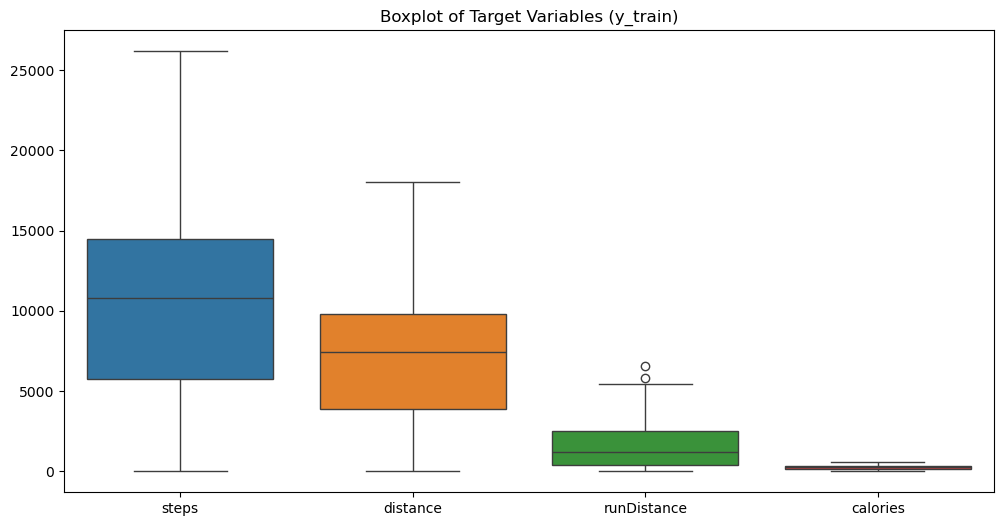

In [3]:
plt.figure(figsize=(12, 6))
sns.boxplot(data)
plt.title("Boxplot of Target Variables (y_train)")
plt.show()

In [4]:
threshold = 5000
outliers = data[data['runDistance'] > threshold]
data_cleaned = data[data['runDistance'] <= threshold]

#Split data

In [5]:
X = data_cleaned[['calories']]
y = data_cleaned[['runDistance', 'distance', 'steps']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate features and target for correlation analysis


In [6]:
data_for_corr = pd.concat([X_train, y_train], axis=1)

# Calculate correlation matrix

In [7]:
corr_matrix = data_for_corr.corr()

# Heatmap for correlation matrix


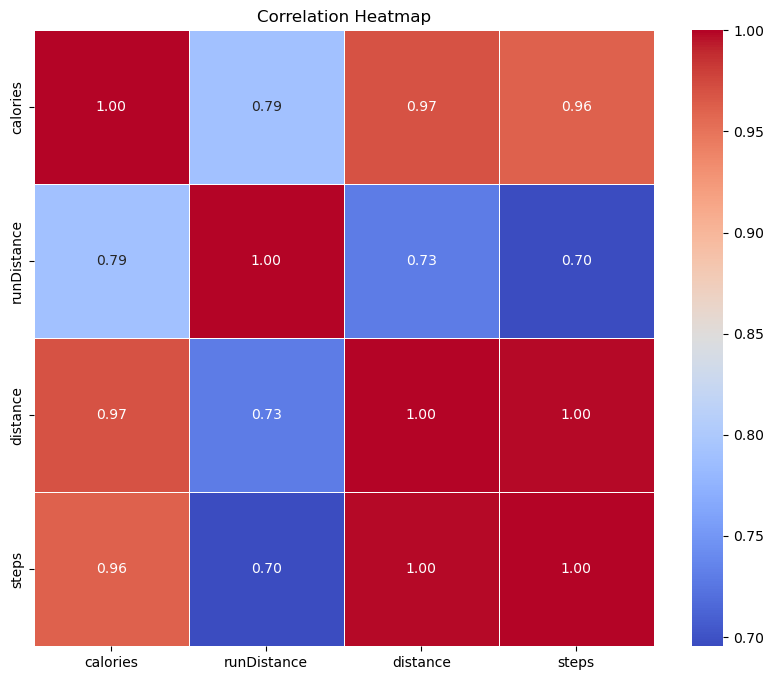

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Normalizing the features


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building and training models


# Ridge Regression


In [10]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)

Ridge()

# Random Forest Regressor


In [11]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

# Gradient Boosting Regressor


In [12]:
gb_model_multioutput = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gb_model_multioutput.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

In [13]:
print("Dimensions after splitting:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Dimensions after splitting:
X_train shape: (236, 1)
y_train shape: (236, 3)


In [14]:
# Support Vector Regressor
svr_model = SVR()

# Param grid for SVR
param_grid_svr = {'estimator__C': [0.1, 1, 10], 'estimator__epsilon': [0.01, 0.1, 1]}

# Wrap SVR in MultiOutputRegressor
svr_multioutput = MultiOutputRegressor(SVR())

# Perform GridSearchCV for each target variable
grid_search_svr = GridSearchCV(svr_multioutput, param_grid_svr, scoring='r2', cv=5)
grid_search_svr.fit(X_train_scaled, y_train)

# Get the best estimator after the grid search
best_svr_model = grid_search_svr.best_estimator_


# Function to evaluate models


In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
    return r2

# Evaluating models


In [16]:
r2_ridge = evaluate_model(ridge_model, X_test_scaled, y_test)
r2_rf = evaluate_model(rf_model, X_test_scaled, y_test)
r2_gb = evaluate_model(gb_model_multioutput, X_test_scaled, y_test)

print({'Ridge Regression': r2_ridge, 'Random Forest': r2_rf, 'Gradient Boosting': r2_gb})

{'Ridge Regression': 0.9430575376509754, 'Random Forest': 0.9027078382395088, 'Gradient Boosting': 0.8748764024460991}


# Interactive prediction function


In [17]:
def predict_distances_steps(model, calories):
    input_data = scaler.transform([[calories]])
    predicted_values = model.predict(input_data)
    return predicted_values

# Selecting the best model based on R2 score

In [18]:
best_model = max((ridge_model, r2_ridge), (rf_model, r2_rf), (gb_model_multioutput, r2_gb), key=lambda pair: pair[1])[0]


# Example usage


In [19]:
import joblib

joblib.dump(best_svr_model, 'Calories_Prediction_fix.h5')

['Calories_Prediction_fix.h5']